# 1. HOTRG

In [ ]:
from all_fn import *

# Parameters setup
model_name = "2D_M=3_XY" #model_name#
symm = True #symm#
dcut = 20#dcut#
Lmax = 2000#Lmax#
unit_size = 1#unit_size#
iteration = 0#iteration#
# iT = 0#iT#

model = Model(model_name, symm)

if iteration == 300:
    Ts_tot = model.Tc
    if type(Ts_tot) != list:
        Ts_tot = [Ts_tot]
elif iteration == 0:
    Ts_tot = np.arange(0.8, 0.96+0.02, 0.02) 
    
# Ts = [Ts_tot[iT]]
Ts = Ts_tot

HOTRG = Hotrg()
HOTRG.dcut = dcut
HOTRG.trgstep = int(np.floor(np.log2(Lmax/unit_size)))
Ls = unit_size * 2**np.arange(0, HOTRG.trgstep+1)

print("{}, symm={}, D={}".format(model.name, model.symm, HOTRG.dcut))
print("L = ", Ls)

# Folders creation
prefix = f"{model.name}{'_symm' if model.symm else ''}/"
Folder_T0    = prefix + f"T0_tensor/"
Folder_Norms = prefix + f"Norms/"
makeFolder(Folder_T0)
makeFolder(Folder_Norms)

for T in Ts:
    for L in Ls:
        print('\nProcessing T = {}, L = {}'.format(T,L))
        if L == unit_size:
            T0 = model.T0_1x1(T)
            T0 = ExactCon.contract_LxL([T0]*unit_size**2, unit_size)
            Norm = max([block.Abs().Max().item() for block in T0.get_blocks()])
            T0 /= Norm                
            Norms = [Norm]

        else:
            T0, Uy, Ny, Sy = HOTRG.update_pure(T0, T0, "y", HOTRG.dcut, "Abs_Max")
            del Uy, Sy
            T0, Ux, Nx, Sx = HOTRG.update_pure(T0, T0, "x", HOTRG.dcut, "Abs_Max")
            Norms = np.append(Norms, Ny**2 * Nx)
            del Ux, Sx, Ny, Nx

        T0.Save(Folder_T0 + "T0_T{}_L{}_D{}_US{}_{}".format(T,L,HOTRG.dcut,unit_size,model.name))
        np.save(Folder_Norms + "Norms_T{}_L{}_D{}_US{}_{}.npy".format(T,L,HOTRG.dcut,unit_size,model.name), Norms)

        print("done")

2D_M=3_XY, symm=True, D=20
L =  [   1    2    4    8   16   32   64  128  256  512 1024]

Processing T = 0.8, L = 1
done

Processing T = 0.8, L = 2
done

Processing T = 0.8, L = 4
done

Processing T = 0.8, L = 8
done

Processing T = 0.8, L = 16
done

Processing T = 0.8, L = 32
done

Processing T = 0.8, L = 64
done

Processing T = 0.8, L = 128
done

Processing T = 0.8, L = 256
done

Processing T = 0.8, L = 512
done

Processing T = 0.8, L = 1024
done

Processing T = 0.8200000000000001, L = 1
done

Processing T = 0.8200000000000001, L = 2
done

Processing T = 0.8200000000000001, L = 4
done

Processing T = 0.8200000000000001, L = 8
done

Processing T = 0.8200000000000001, L = 16
done

Processing T = 0.8200000000000001, L = 32
done

Processing T = 0.8200000000000001, L = 64
done

Processing T = 0.8200000000000001, L = 128
done

Processing T = 0.8200000000000001, L = 256
done

Processing T = 0.8200000000000001, L = 512
done

Processing T = 0.8200000000000001, L = 1024
done

Processing T = 0.

# 2. Diagonalization

In [ ]:
from all_fn import *

model_name = "2D_M=3_XY"# model_name#
symm = True#symm#
dcut = 20#dcut#
Lmax = 2000#Lmax#
unit_size = 1#unit_size#
iteration = 0#iteration#
# iT = 0#iT#
# iL = 5#iL#
n = 2#n#
num_collect = 120#num_collect#
hermitian = False#hermitian#

model = Model(model_name, symm)

if iteration == 300:
    Ts_tot = model.Tc
    if type(Ts_tot) != list:
        Ts_tot = [Ts_tot]
elif iteration == 0:
    Ts_tot = np.arange(0.8, 0.96+0.02, 0.02)

# Ts = [Ts_tot[iT]]
Ts = Ts_tot

HOTRG = Hotrg()
HOTRG.dcut = dcut
trgstep = int(np.floor(np.log2(Lmax/unit_size)))
Ls_tot = unit_size * 2**np.arange(0, trgstep+1)
# Ls = [Ls_tot[iL]]
Ls = Ls_tot

print("{}, symm={}, D={}".format(model.name, model.symm, HOTRG.dcut))
print("L = ", Ls)
print("D={}, n={}, num_collect={}".format(HOTRG.dcut,n,num_collect))

# make folders
prefix = f"{model.name}{'_symm' if model.symm else ''}/"
Folder_Yi_raw = prefix + f"Yi_raw_data_wo_trans_num_collect{num_collect}/"
Folder_Zi_raw = prefix + f"Zi_raw_data_wo_trans_num_collect{num_collect}/"
makeFolder(Folder_Yi_raw)
makeFolder(Folder_Zi_raw)

for T in Ts:
    for L in Ls:
        print('\nProcessing T = {}, L = {}'.format(T,L))
        Folder_T0 = prefix + f'T0_tensor/'
        T0 = cy.UniTensor.Load(Folder_T0 + "T0_T{}_L{}_D{}_US{}_{}.cytnx".format(T,L,HOTRG.dcut,unit_size,model.name))

        bi   = T0.bonds()[1]
        bi_n = bi.combineBonds([bi]*(n-1))
        d_x_n_sector_s = bi_n.getDegeneracies()

        if (n == 1) or (np.max(d_x_n_sector_s)-2 <= num_collect):
            print("Exact Diagonalization!")

            TM_n_traced = ExactCon.tTr_n([T0]*n)
            if hermitian:
                Y, Z = cy.linalg.Eigh(TM_n_traced)
            else:
                Y, Z = cy.linalg.Eig(TM_n_traced)
                    
            Y.Save(Folder_Yi_raw + f"Y_T{T}_L{L}_D{HOTRG.dcut}_n{n}_US{unit_size}")
            Z.Save(Folder_Zi_raw + f"Z_T{T}_L{L}_D{HOTRG.dcut}_n{n}_US{unit_size}")

            print("done")

        else:
            for iq, qnum in enumerate(bi_n.qnums()):
                qnum = qnum[0]
                print("Partial Diagonalization!")
                d_x_n_sector = d_x_n_sector_s[iq]
                k  = np.min([num_collect, d_x_n_sector - 2])
                bo = cy.Bond(cy.BD_OUT, [[qnum]],[1], [cy.Symmetry.Zn(model.q)])

                phi_symm = cy.UniTensor([bi]*n + [bo], dtype=cy.Type.ComplexDouble)
                for isector, sector in enumerate(phi_symm.get_blocks()):
                    phi_symm.put_block(cy.random.uniform(sector.shape(), low=-1., high=1., dtype=cy.Type.ComplexDouble), isector)
                
                LinOp = LinOp_n_PBC(d_x_n_sector, cy.Type.ComplexDouble, T0=T0, P0=None, qnum=qnum, n=n, get_momentum=False)
                
                try:            
                    _ = cy.linalg.Lanczos(LinOp, k=k, Tin=phi_symm, which="LM", Maxiter=999999)
                    Y = _[0]; Z_list = _[1:]

                    Y.Save(Folder_Yi_raw + f"Y_qnum{qnum}_T{T}_L{L}_D{HOTRG.dcut}_n{n}_US{unit_size}")
                    for iZ, Z in enumerate(Z_list):
                        Z.Save(Folder_Zi_raw + f"Z{iZ}_qnum{qnum}_T{T}_L{L}_D{HOTRG.dcut}_n{n}_US{unit_size}")

                    print("done")
                except:
                    print("partial diagonalization due to num_collect={} > d_x_n_sector={}".format(num_collect, d_x_n_sector))
                    pass

2D_M=3_XY, symm=True, D=20
L =  [   1    2    4    8   16   32   64  128  256  512 1024]
D=20, n=2, num_collect=120

Processing T = 0.8, L = 1
Exact Diagonalization!
done

Processing T = 0.8, L = 2
Exact Diagonalization!
done

Processing T = 0.8, L = 4
Exact Diagonalization!
done

Processing T = 0.8, L = 8
Exact Diagonalization!
done

Processing T = 0.8, L = 16
Exact Diagonalization!
done

Processing T = 0.8, L = 32
Exact Diagonalization!
done

Processing T = 0.8, L = 64
Exact Diagonalization!
done

Processing T = 0.8, L = 128
Exact Diagonalization!
done

Processing T = 0.8, L = 256
Exact Diagonalization!
done

Processing T = 0.8, L = 512
Exact Diagonalization!
done

Processing T = 0.8, L = 1024
Exact Diagonalization!
done

Processing T = 0.8200000000000001, L = 1
Exact Diagonalization!
done

Processing T = 0.8200000000000001, L = 2
Exact Diagonalization!
done

Processing T = 0.8200000000000001, L = 4
Exact Diagonalization!
done

Processing T = 0.8200000000000001, L = 8
Exact Diagonali

# 3. Data Processing & plot figure

In [32]:
from all_fn import *

model_name = "2D_M=3_XY"# model_name#
symm = True#symm#
dcut = 20#dcut#
Lmax = 2000#Lmax#
unit_size = 1#unit_size#
iteration = 0#iteration#

n = 2#n#
num_collect = 120#num_collect#
hermitian = False#hermitian#

model = Model(model_name, symm)

HOTRG = Hotrg()
HOTRG.dcut = dcut
trgstep = int(np.floor(np.log2(Lmax/unit_size)))
Ls_tot = unit_size * 2**np.arange(0, trgstep+1)
# Ls = [Ls_tot[iL]]
Ls = Ls_tot

if iteration == 300:
    Tc = model.Tc
    if type(Tc) != list:
        Ts_tot = [Tc]
elif iteration == 0:
    Ts_tot = np.arange(0.8, 0.96+0.02, 0.02)

prefix = f"{model.name}{'_symm' if model.symm else ''}/"
Folder_Yi_raw = prefix + f"Yi_raw_data_wo_trans_num_collect{num_collect}/"
Folder_Zi_raw = prefix + f"Zi_raw_data_wo_trans_num_collect{num_collect}/"

Yi_wo_norm_all = np.full((len(Ts_tot), len(Ls_tot), model.q, num_collect), fill_value=np.nan+1j*np.nan)

for iT,T in enumerate(Ts_tot):
    for iL,L in enumerate(Ls_tot):
        try:
            Y = cy.UniTensor.Load(Folder_Yi_raw + f"Y_T{T}_L{L}_D{HOTRG.dcut}_n{n}_US{unit_size}.cytnx")
            for qnum in range(model.q):
                Y_qnum = Y.get_block(qnum).numpy()
                piv = np.argsort(-np.log(Y_qnum))
                Y_qnum = Y_qnum[piv]
                dc = np.min([len(Y_qnum), num_collect])
                Yi_wo_norm_all[iT, iL, qnum, :dc] = (Y_qnum)**(1/L)
        
        except:
            for qnum in range(model.q):
                Y_qnum = cy.UniTensor.Load(Folder_Yi_raw + f"Y_qnum{qnum}_T{T}_L{L}_D{HOTRG.dcut}_n{n}_US{unit_size}.cytnx")
                Y_qnum = Y_qnum.get_block().numpy()
                piv = np.argsort(-np.log(Y_qnum))
                Y_qnum = Y_qnum[piv]
                dc = np.min([len(Y_qnum), num_collect])
                Yi_wo_norm_all[iT, iL, qnum, :dc] = (Y_qnum)**(1/L)

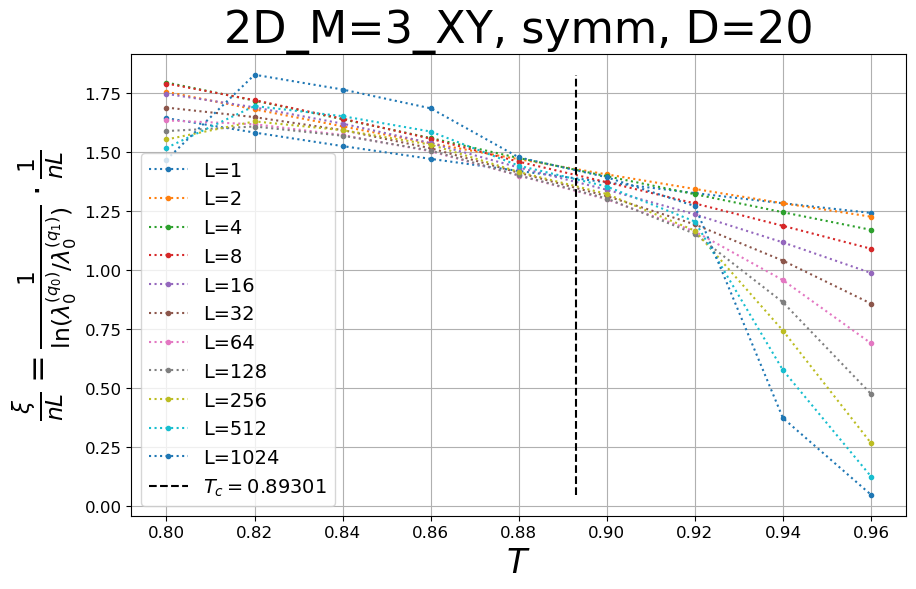

In [35]:
plt.figure(figsize=(10,6))

for iL,L in enumerate(Ls_tot):
    Y0_qnum0 = np.real(Yi_wo_norm_all[:, iL, 0, 0])
    Y0_qnum1 = np.real(Yi_wo_norm_all[:, iL, 1, 0])

    xi = 1/np.log(Y0_qnum0/ Y0_qnum1)
    x = Ts_tot
    y = xi/(n*L)
    plt.plot(x, y, ".:", label="L={}".format(L))

plt.plot(model.Tc*np.ones(2), [min(y), max(y)], "k--", label="$T_c={}$".format(model.Tc))

plt.grid()
plt.ylabel(r"$\frac{\xi}{nL}=\frac{1}{\ln(\lambda_0^{(q_0)}/\lambda_0^{(q_1)})} \cdot \frac{1}{nL}$", fontsize=24)
plt.xlabel(r"$T$", fontsize=24)

plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
plt.title(f"{model.name}, {'symm' if model.symm else 'wo symm'}, D={HOTRG.dcut}", fontsize=32)

Folder_plt = "figures/"
makeFolder(Folder_plt)
plt.savefig(Folder_plt + "xi_over_Ly_vs_T_D{}_{}.pdf".format(HOTRG.dcut, model.name))
# plt.yscale("log")